# This notebook recreates plots in the results section of the paper

In [42]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

plotpar = {'axes.labelsize': 40,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 35,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [43]:
df = pd.read_csv("data/simulated_data.csv")
true_age_gyr = (10**df.age.values)*1e-9

Load samples

simulation_results/iso_and_gyro/0sun_samples.h5


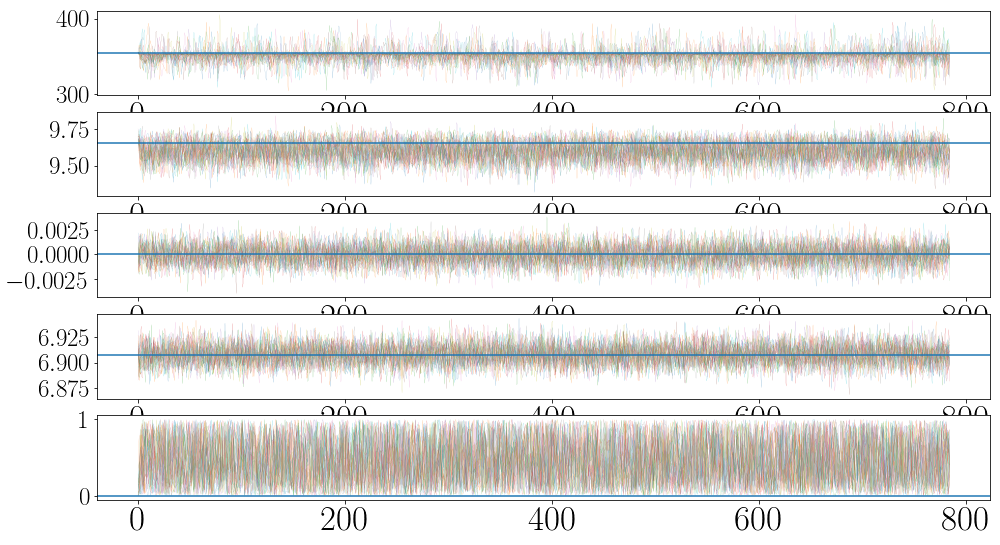

In [40]:
i = "sun"
savedir = "simulation_results/iso_and_gyro"
fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
print(fname)
reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()

truths = [355, np.log10(4.56*1e9), 0., np.log(1000), 0.]
plt.figure(figsize=(16, 9))
for j in range(5):
    plt.subplot(5, 1, j+1)
    plt.plot(samples[:, :, j], alpha=1, lw=.1)
    plt.axhline(truths[j])

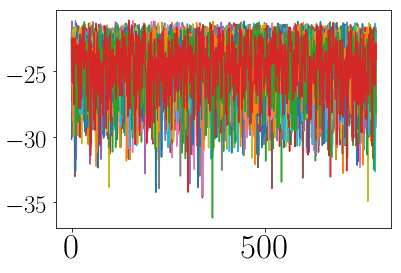

In [41]:
lnprob = reader.get_log_prob(discard=1)
plt.plot(lnprob);

In [101]:
savedir = "simulation_results/iso_and_gyro"
meds, stds, age_samps, resids, errp, errm = [], [], [], [], [], []
N = 68

for i in range(N):
    fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    reader = emcee.backends.HDFBackend(fname)
    samples = reader.get_chain(flat=True)
    age_samps.append((10**samples[:, 1])*1e-9)
    resids.append(list(np.array(age_samps[i]) - true_age_gyr[i]))
    meds.append(np.median(age_samps[i]))
    stds.append(np.std(age_samps[i]))
    upper = np.percentile(age_samps[i], 84)
    lower = np.percentile(age_samps[i], 16)
    errp.append(upper-meds[i])
    errm.append(meds[i]-lower)
meds, stds, errp, errm = np.array(meds), np.array(stds), np.array(errp), np.array(errm)

[ 2  5 10 12 13 17 18 21 22 30 32 37 44 45 46 48 53 57 64 67]
[12.73443684 10.75187654  0.9537836  12.73690562  7.68767921  0.79461586
 13.50582486  1.20548137  6.15370981  5.21833602  2.54183219  2.04937977
  2.73795629 13.26692498 11.97466751  6.74099007  7.41878576 11.11475569
 12.37435504  6.59173115]
[ 1.59533316  8.83863462  0.10929316  8.60412441  6.20782377  0.40984724
 11.47540705  0.17035451  5.53301283  4.23610521  1.12215203  1.13710089
  1.925176   10.44872181  7.76504825  5.96163684  6.40795674  7.92998307
  5.01909886  4.96681133]


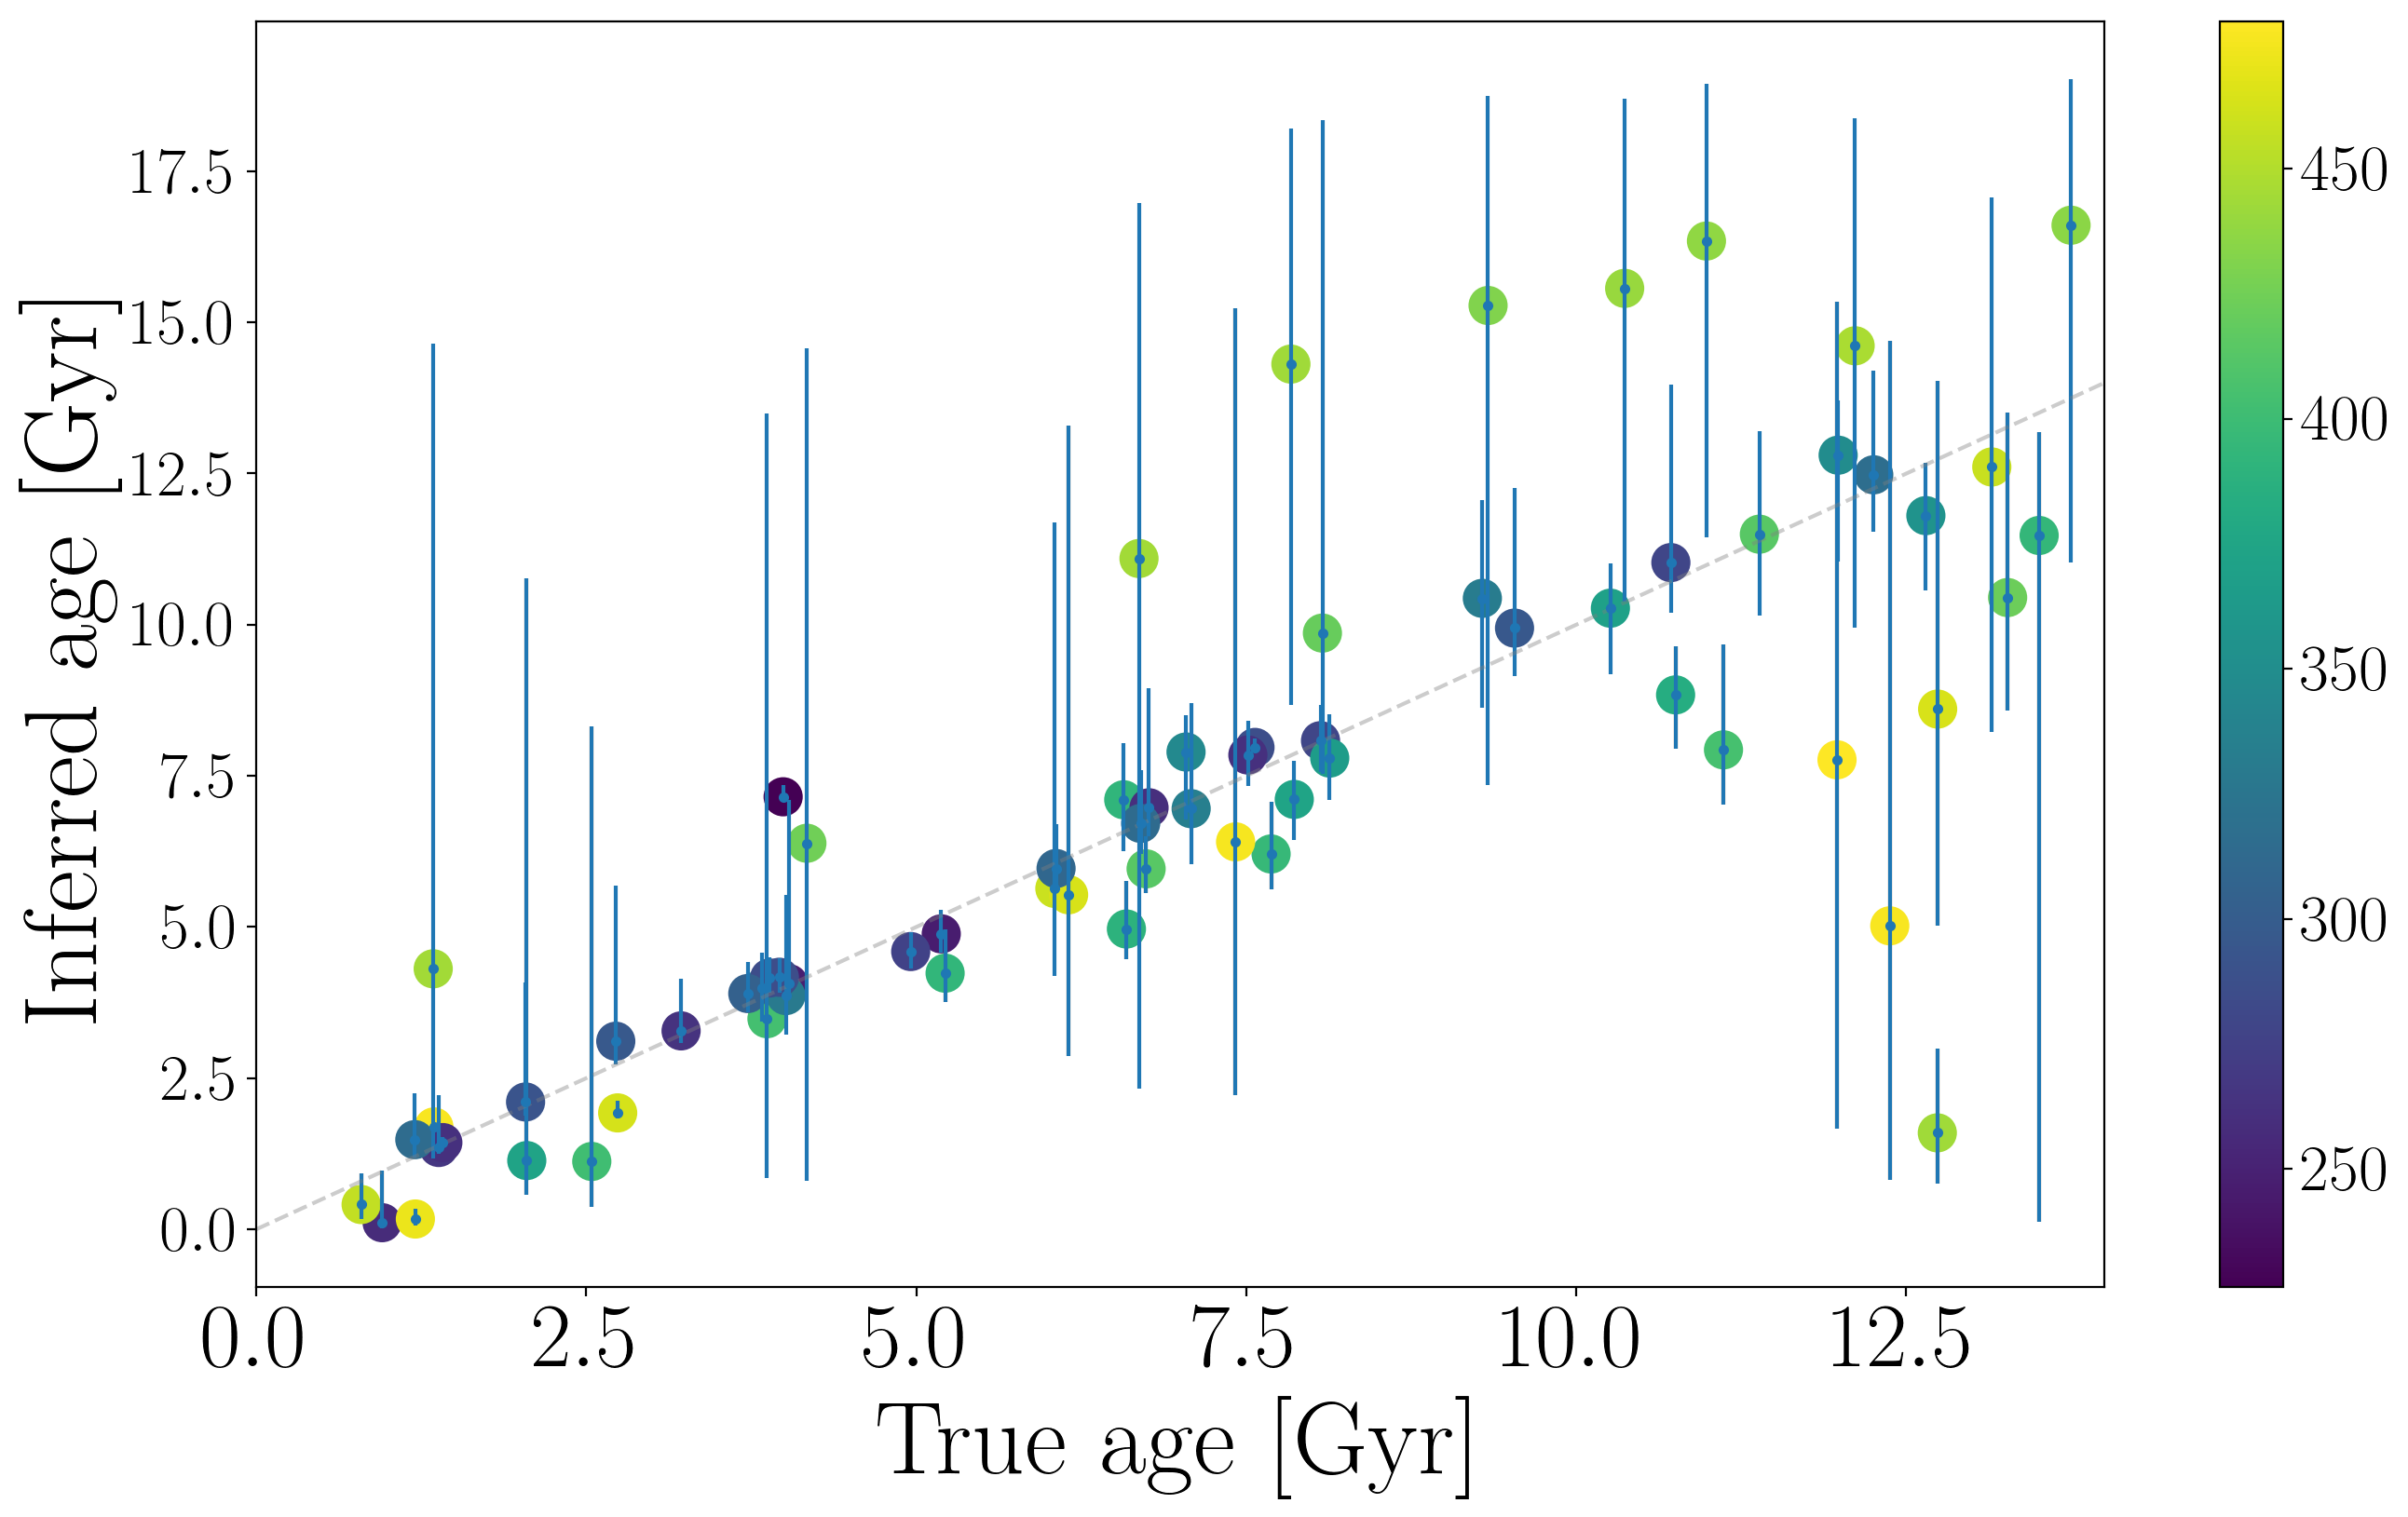

In [102]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(true_age_gyr[:N], meds, yerr=[errm, errp], fmt=".")

m = meds < true_age_gyr[:N] - .1*true_age_gyr[:N]
print(np.arange(N)[m])
print(true_age_gyr[:N][m])
plt.errorbar(true_age_gyr[:N][m], meds[m], yerr=[errm[m], errp[m]], fmt=".", 
             zorder=0, color="tab:orange")
plt.scatter(true_age_gyr[:N], meds, c=df.eep.values[:N], s=200, zorder=1)
# plt.errorbar(true_age_gyr[:N][m], meds[m], yerr=stds[m], fmt=".", color="tab:orange")
print(meds[m])
             
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.colorbar()
plt.savefig("iso_and_gyro.pdf")

In [118]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar(true_age_gyr[:N], meds, yerr=[errm, errp], fmt=".")

# m = meds < true_age_gyr[:N] - .1*true_age_gyr[:N]
# print(np.arange(N)[m])
# print(true_age_gyr[:N][m])
# plt.errorbar(true_age_gyr[:N][m], meds[m], yerr=[errm[m], errp[m]], fmt=".", 
#              zorder=0, color="tab:orange")
# plt.scatter(true_age_gyr[:N], meds, c=df.teff.values[:N], s=200, zorder=1)
# # plt.errorbar(true_age_gyr[:N][m], meds[m], yerr=stds[m], fmt=".", color="tab:orange")
# print(meds[m])
             
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# xs = np.linspace(0, 14, 100)
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(0, 14)
# plt.colorbar()
# plt.savefig("iso_and_gyro.pdf")

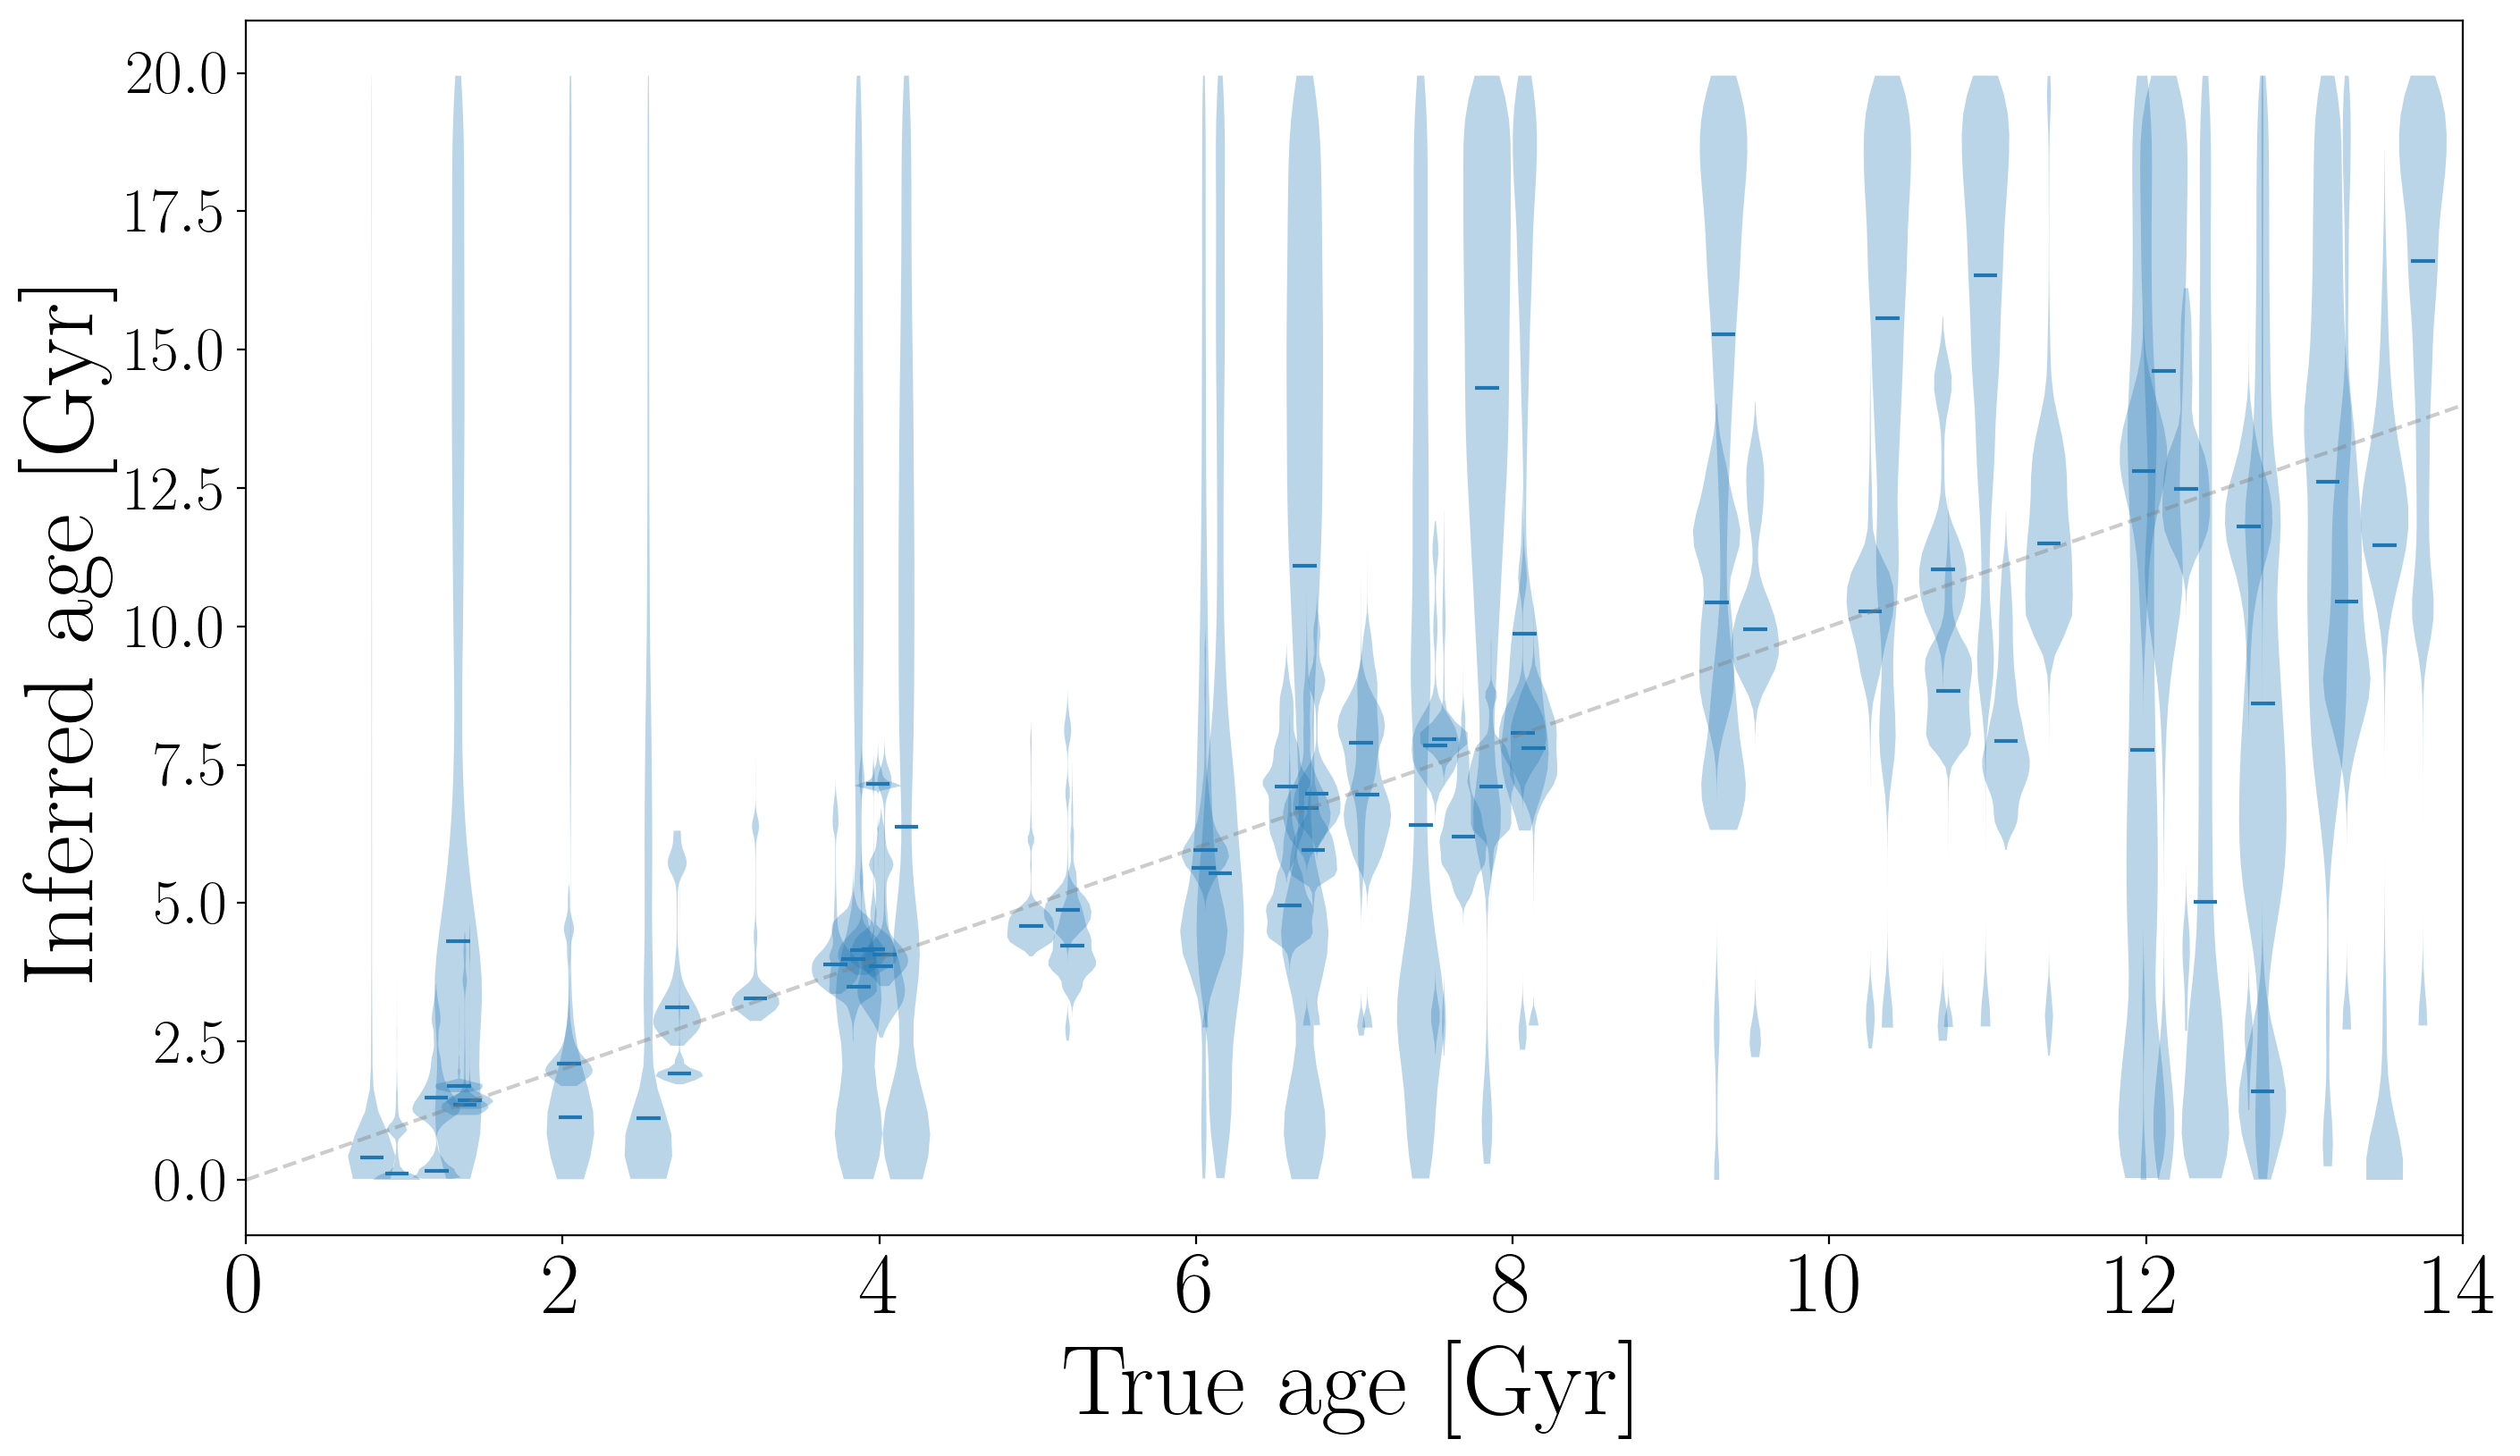

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)

# axes.violinplot(resids, true_age_gyr[:N], points=50, widths=0.3, 
#                 showmeans=False, showextrema=False, showmedians=False)
axes.violinplot(age_samps, true_age_gyr[:N], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=True)
#       age_samps-true_age_gyr[:N]       
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.plot(xs, np.zeros(len(xs)), ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
# plt.ylim(-4, 2)
plt.savefig("iso_and_gyro_violin.pdf")

Precision plot

Text(0,0.5,'$\\log(g)$')

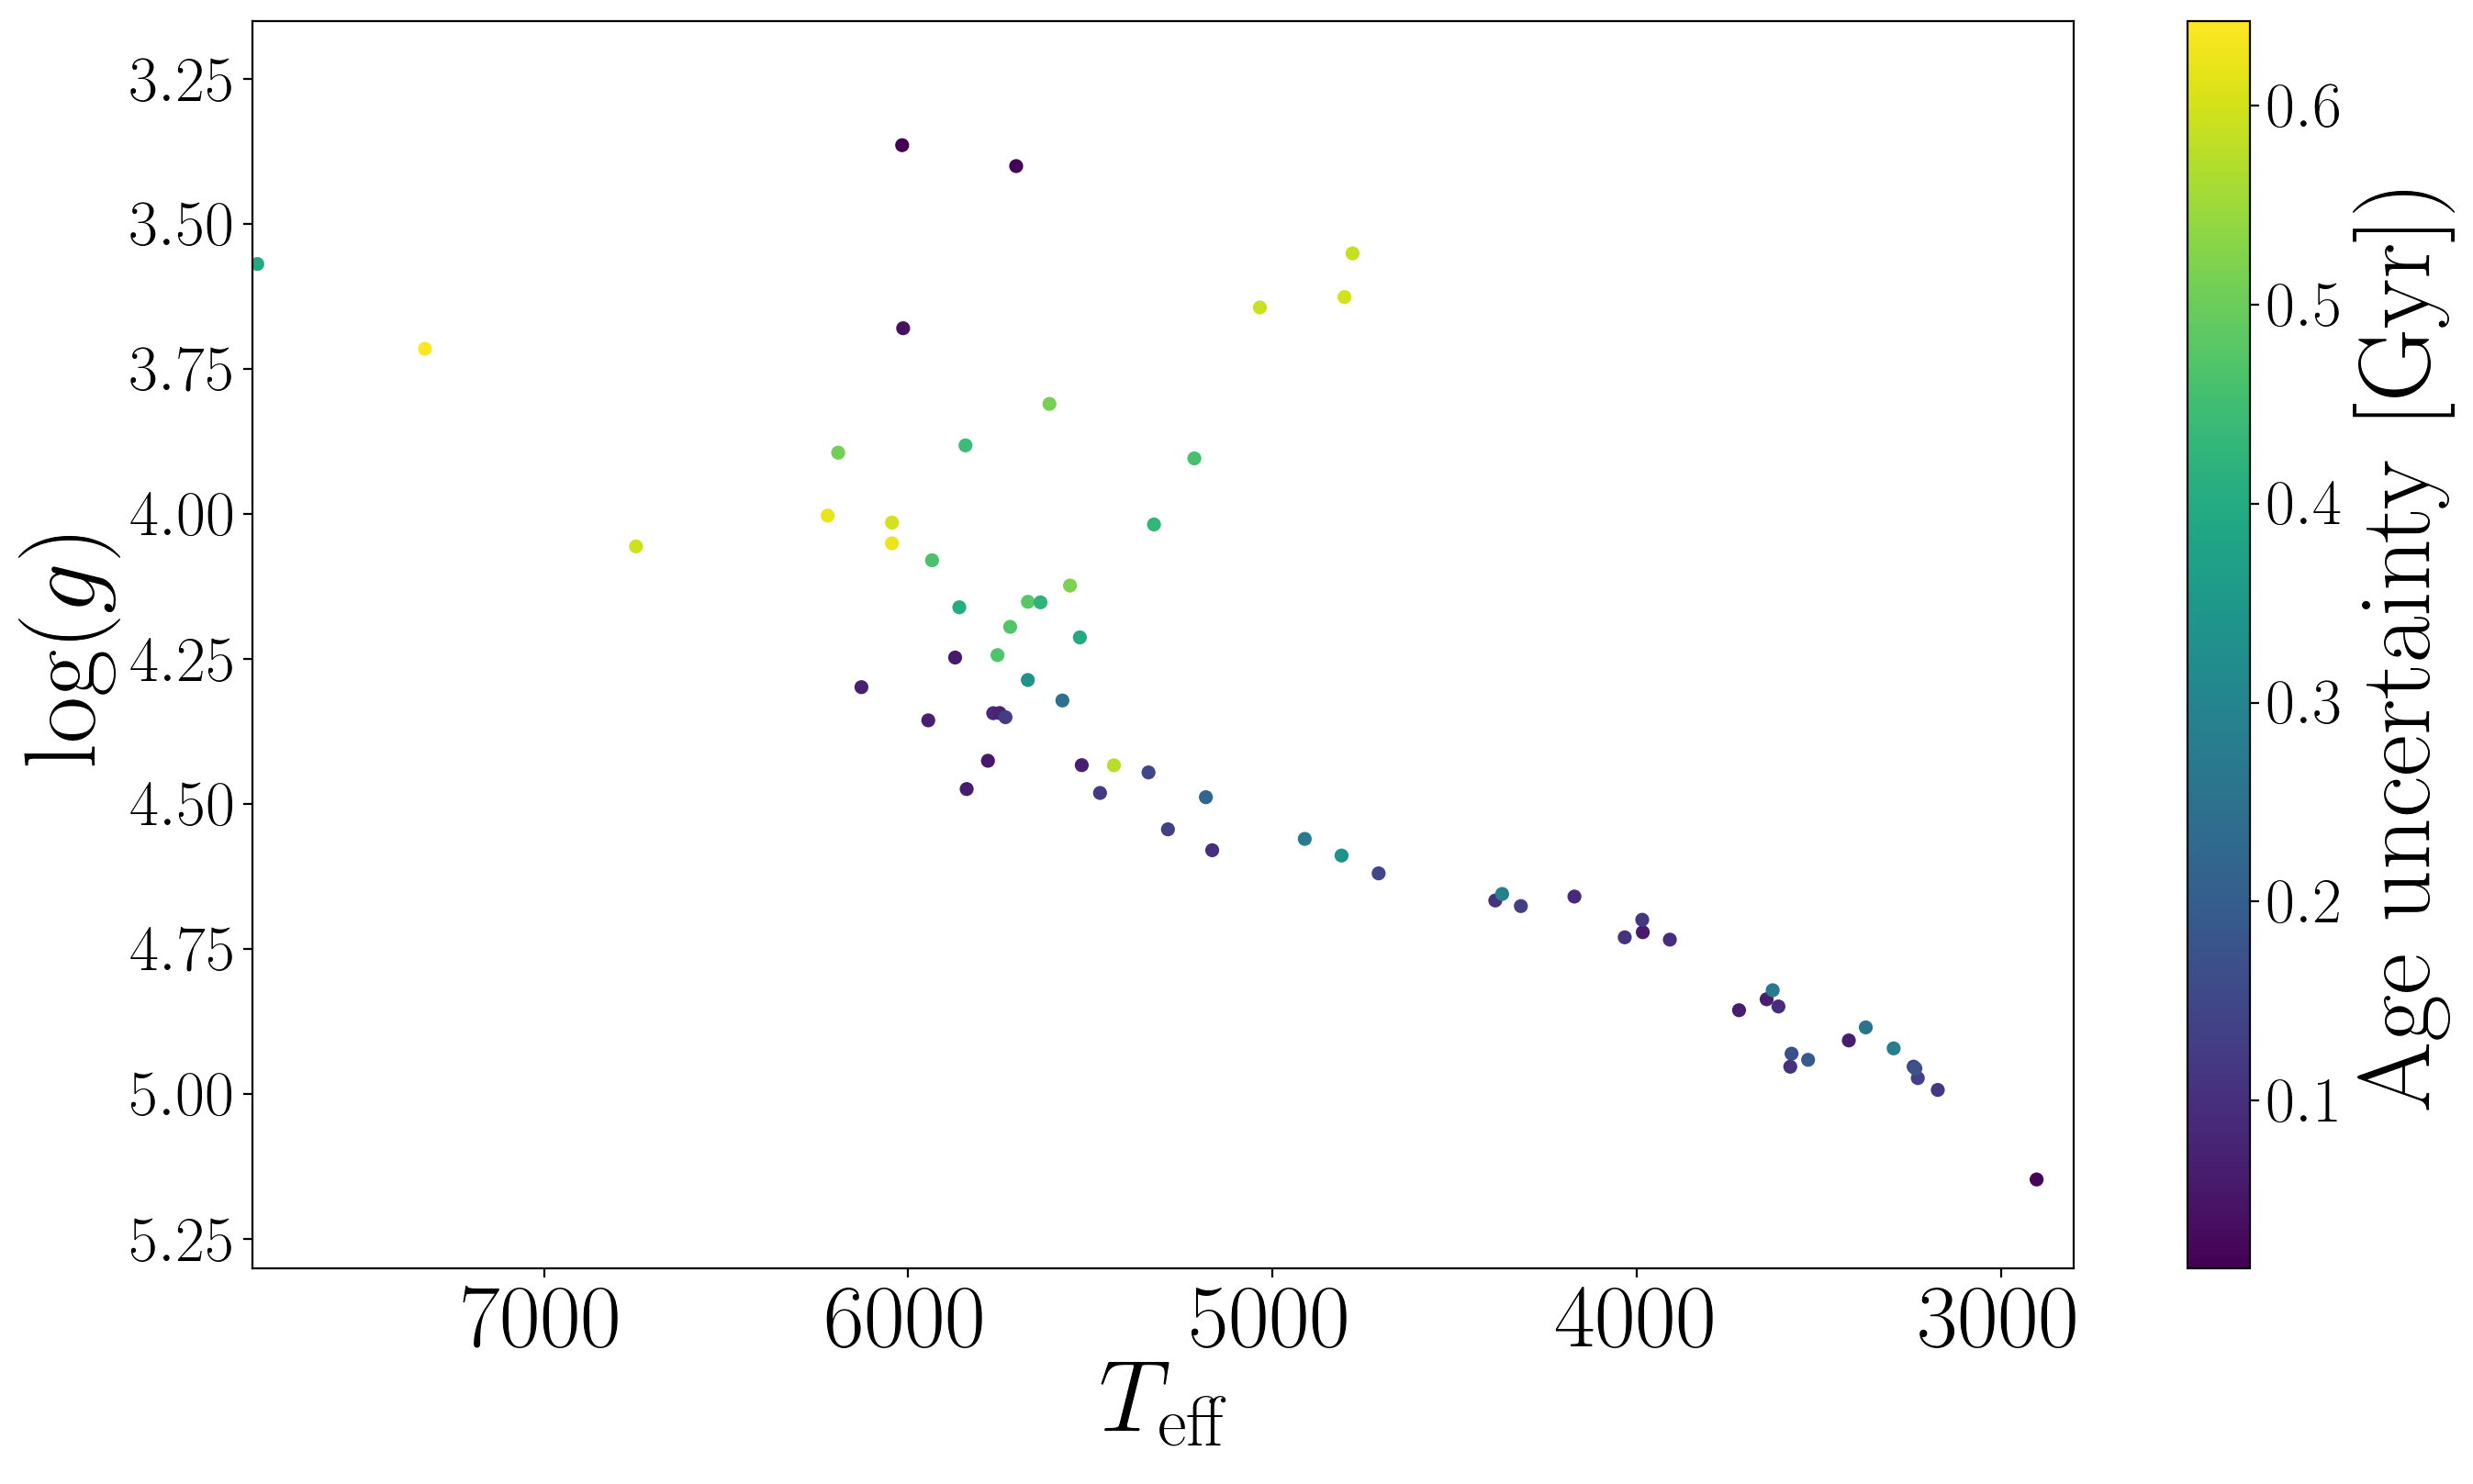

In [104]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=stds/df.age.values[:N], s=20)
plt.colorbar(label="$\mathrm{Age~uncertainty~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Error plot (accuracy)

Text(0,0.5,'$\\log(g)$')

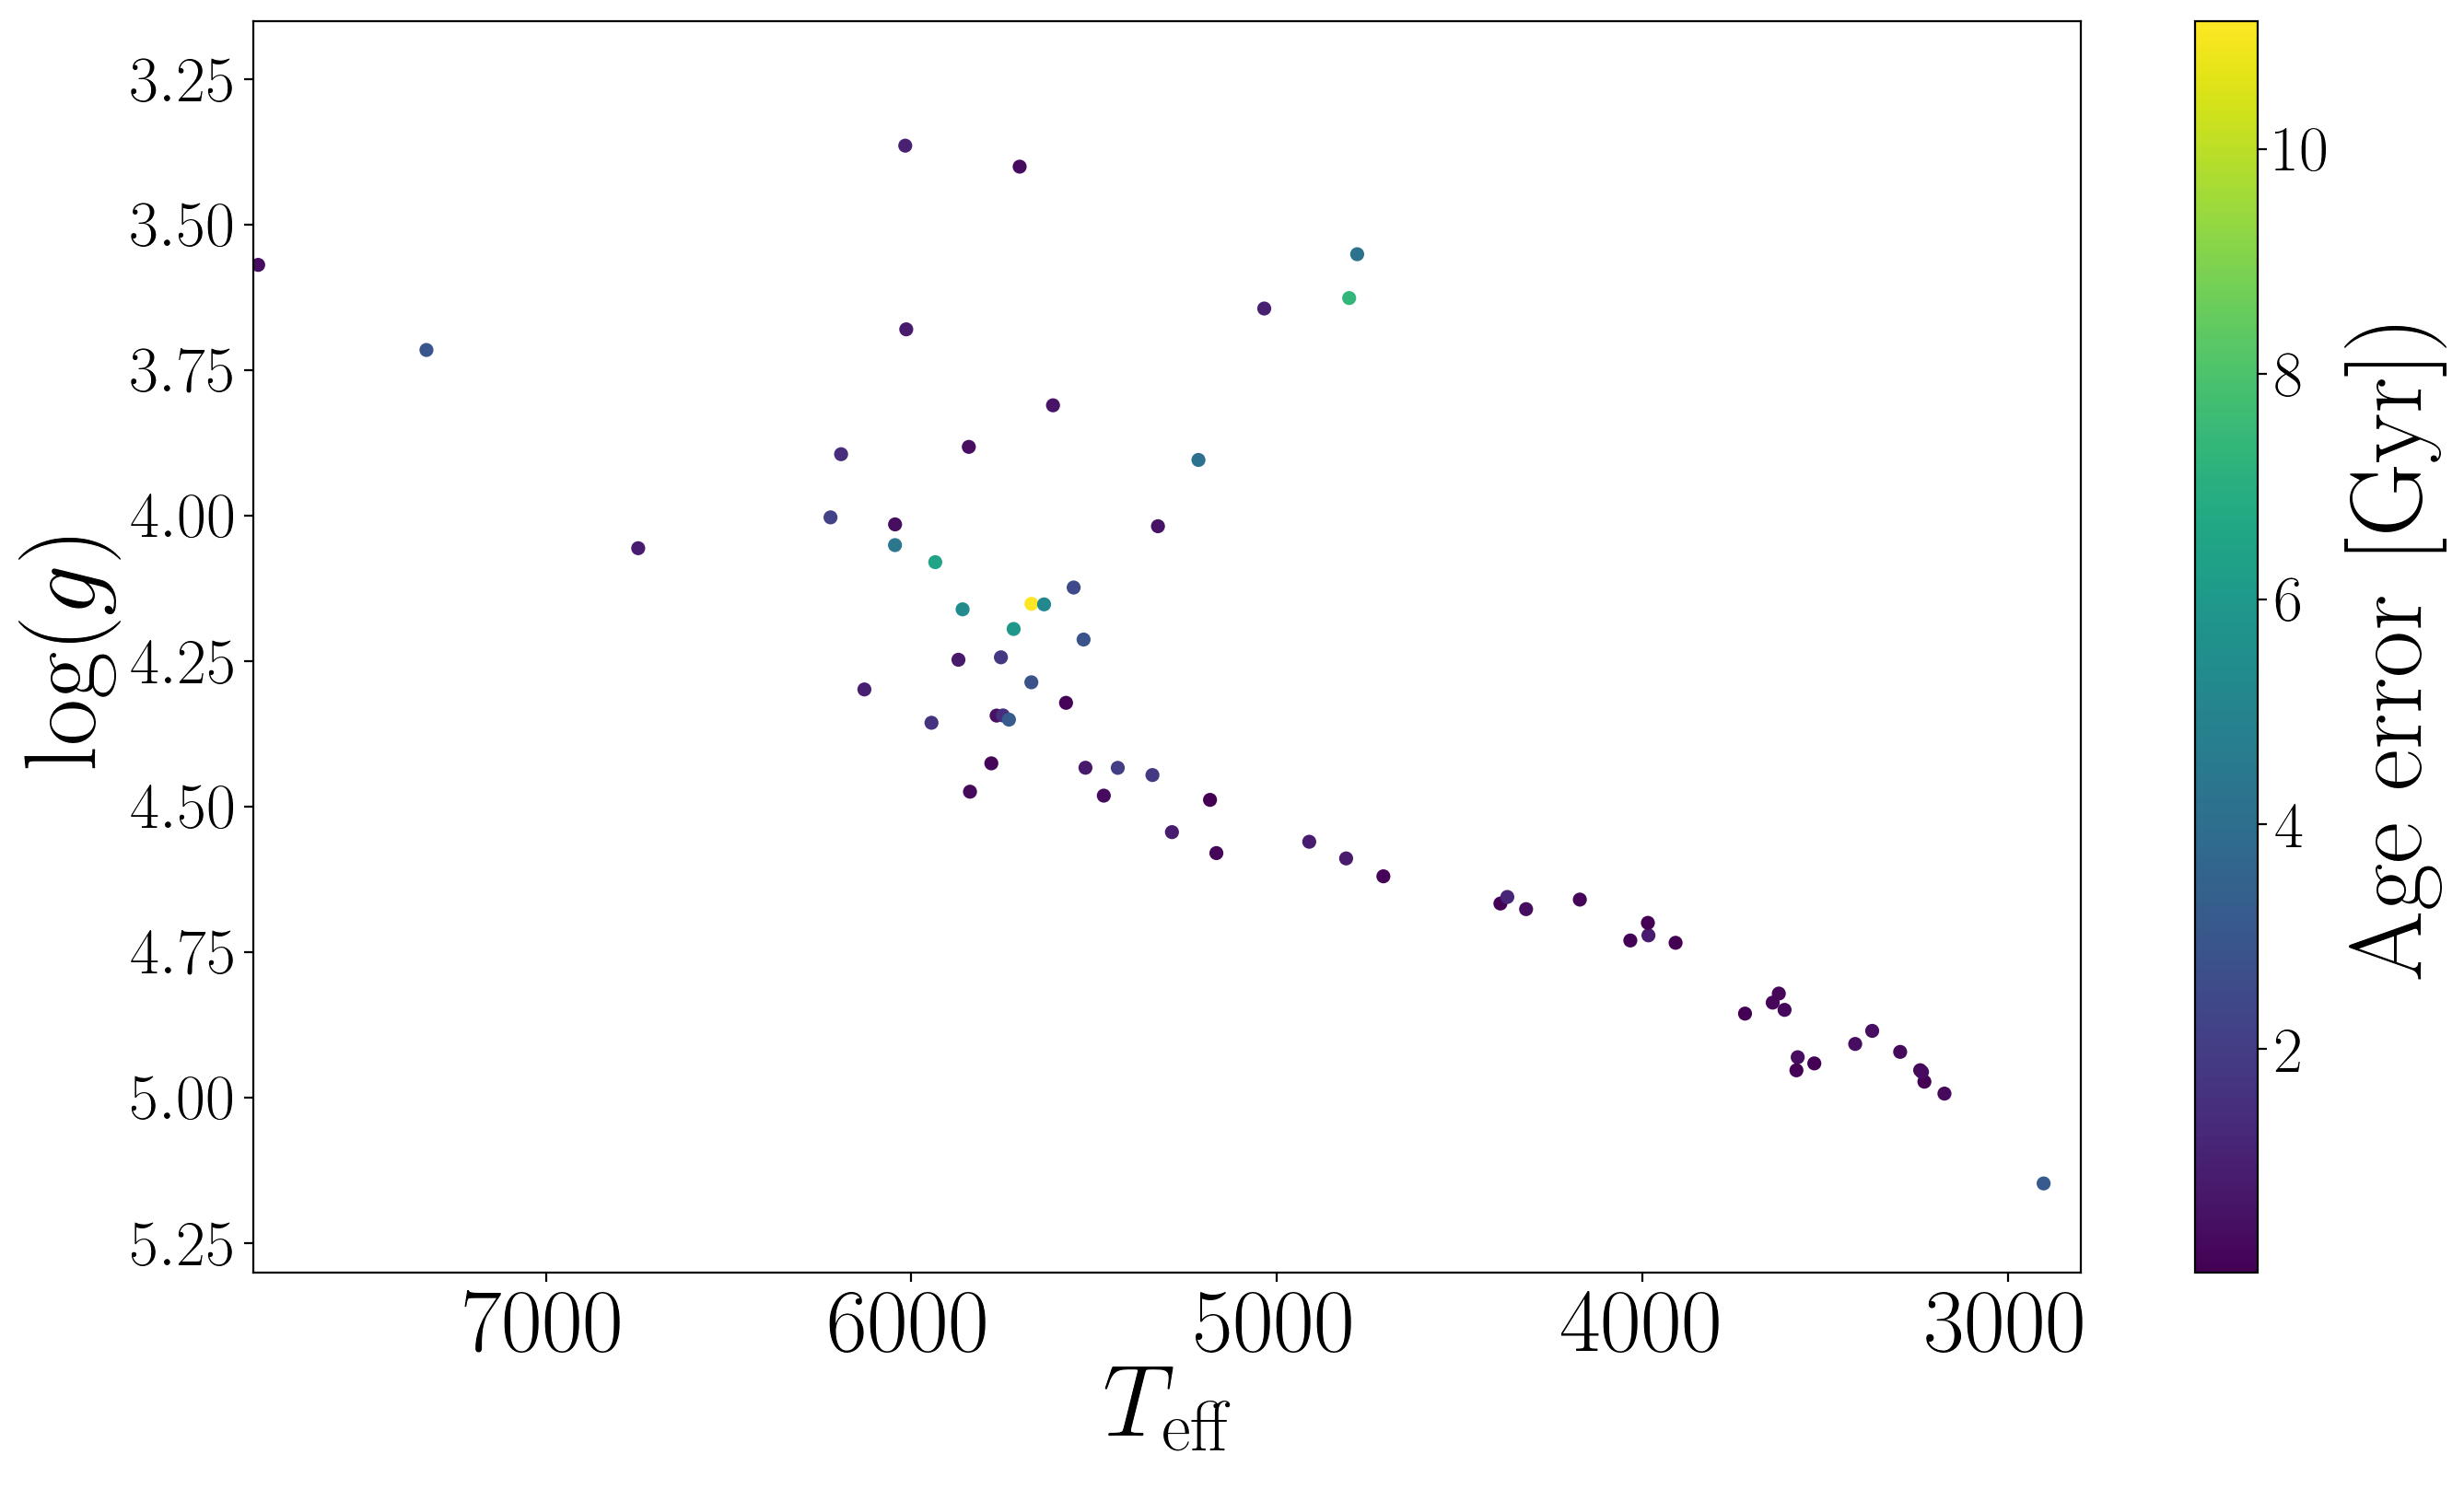

In [105]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=abs(true_age_gyr[:N] - meds), s=20)
plt.colorbar(label="$\mathrm{Age~error~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the isochrone model.

simulation_results/iso_only/0001_samples.h5


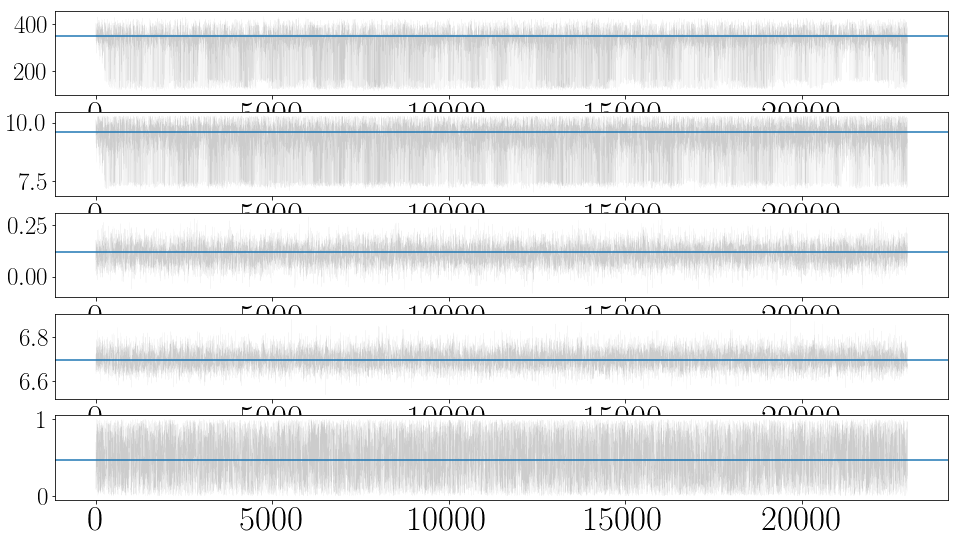

In [106]:
i = 1
savedir = "simulation_results/iso_only"
fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
print(fname)
reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain(flat=True)

truths = [df.eep[i], df.age[i], df.feh[i], np.log(df.d_kpc[i]*1e3), df.Av[i]]
plt.figure(figsize=(16, 9))
for j in range(5):
    plt.subplot(5, 1, j+1)
    plt.plot(samples[1000:, j], alpha=.2, color="k", lw=.1)
    plt.axhline(truths[j])

In [112]:
savedir = "simulation_results/iso_only"
meds_iso, stds_iso, age_samps_iso, resids_iso, errp, errm = [], [], [], [], [], []
N_iso = 64

for i in range(N_iso):
    fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    reader = emcee.backends.HDFBackend(fname)
    samples_iso = reader.get_chain(flat=True)
    age_samps_iso.append((10**samples_iso[:, 1])*1e-9)
    resids_iso.append(list(np.array(age_samps_iso[i]) - true_age_gyr[i]))
    meds_iso.append(np.median(age_samps_iso[i]))
    stds_iso.append(np.std(age_samps_iso[i]))
    upper = np.percentile(age_samps_iso[i], 84)
    lower = np.percentile(age_samps_iso[i], 16)
    errp.append(upper)# - meds[i])
    errm.append(lower)
meds_iso, stds_iso = np.array(meds_iso), np.array(stds_iso)

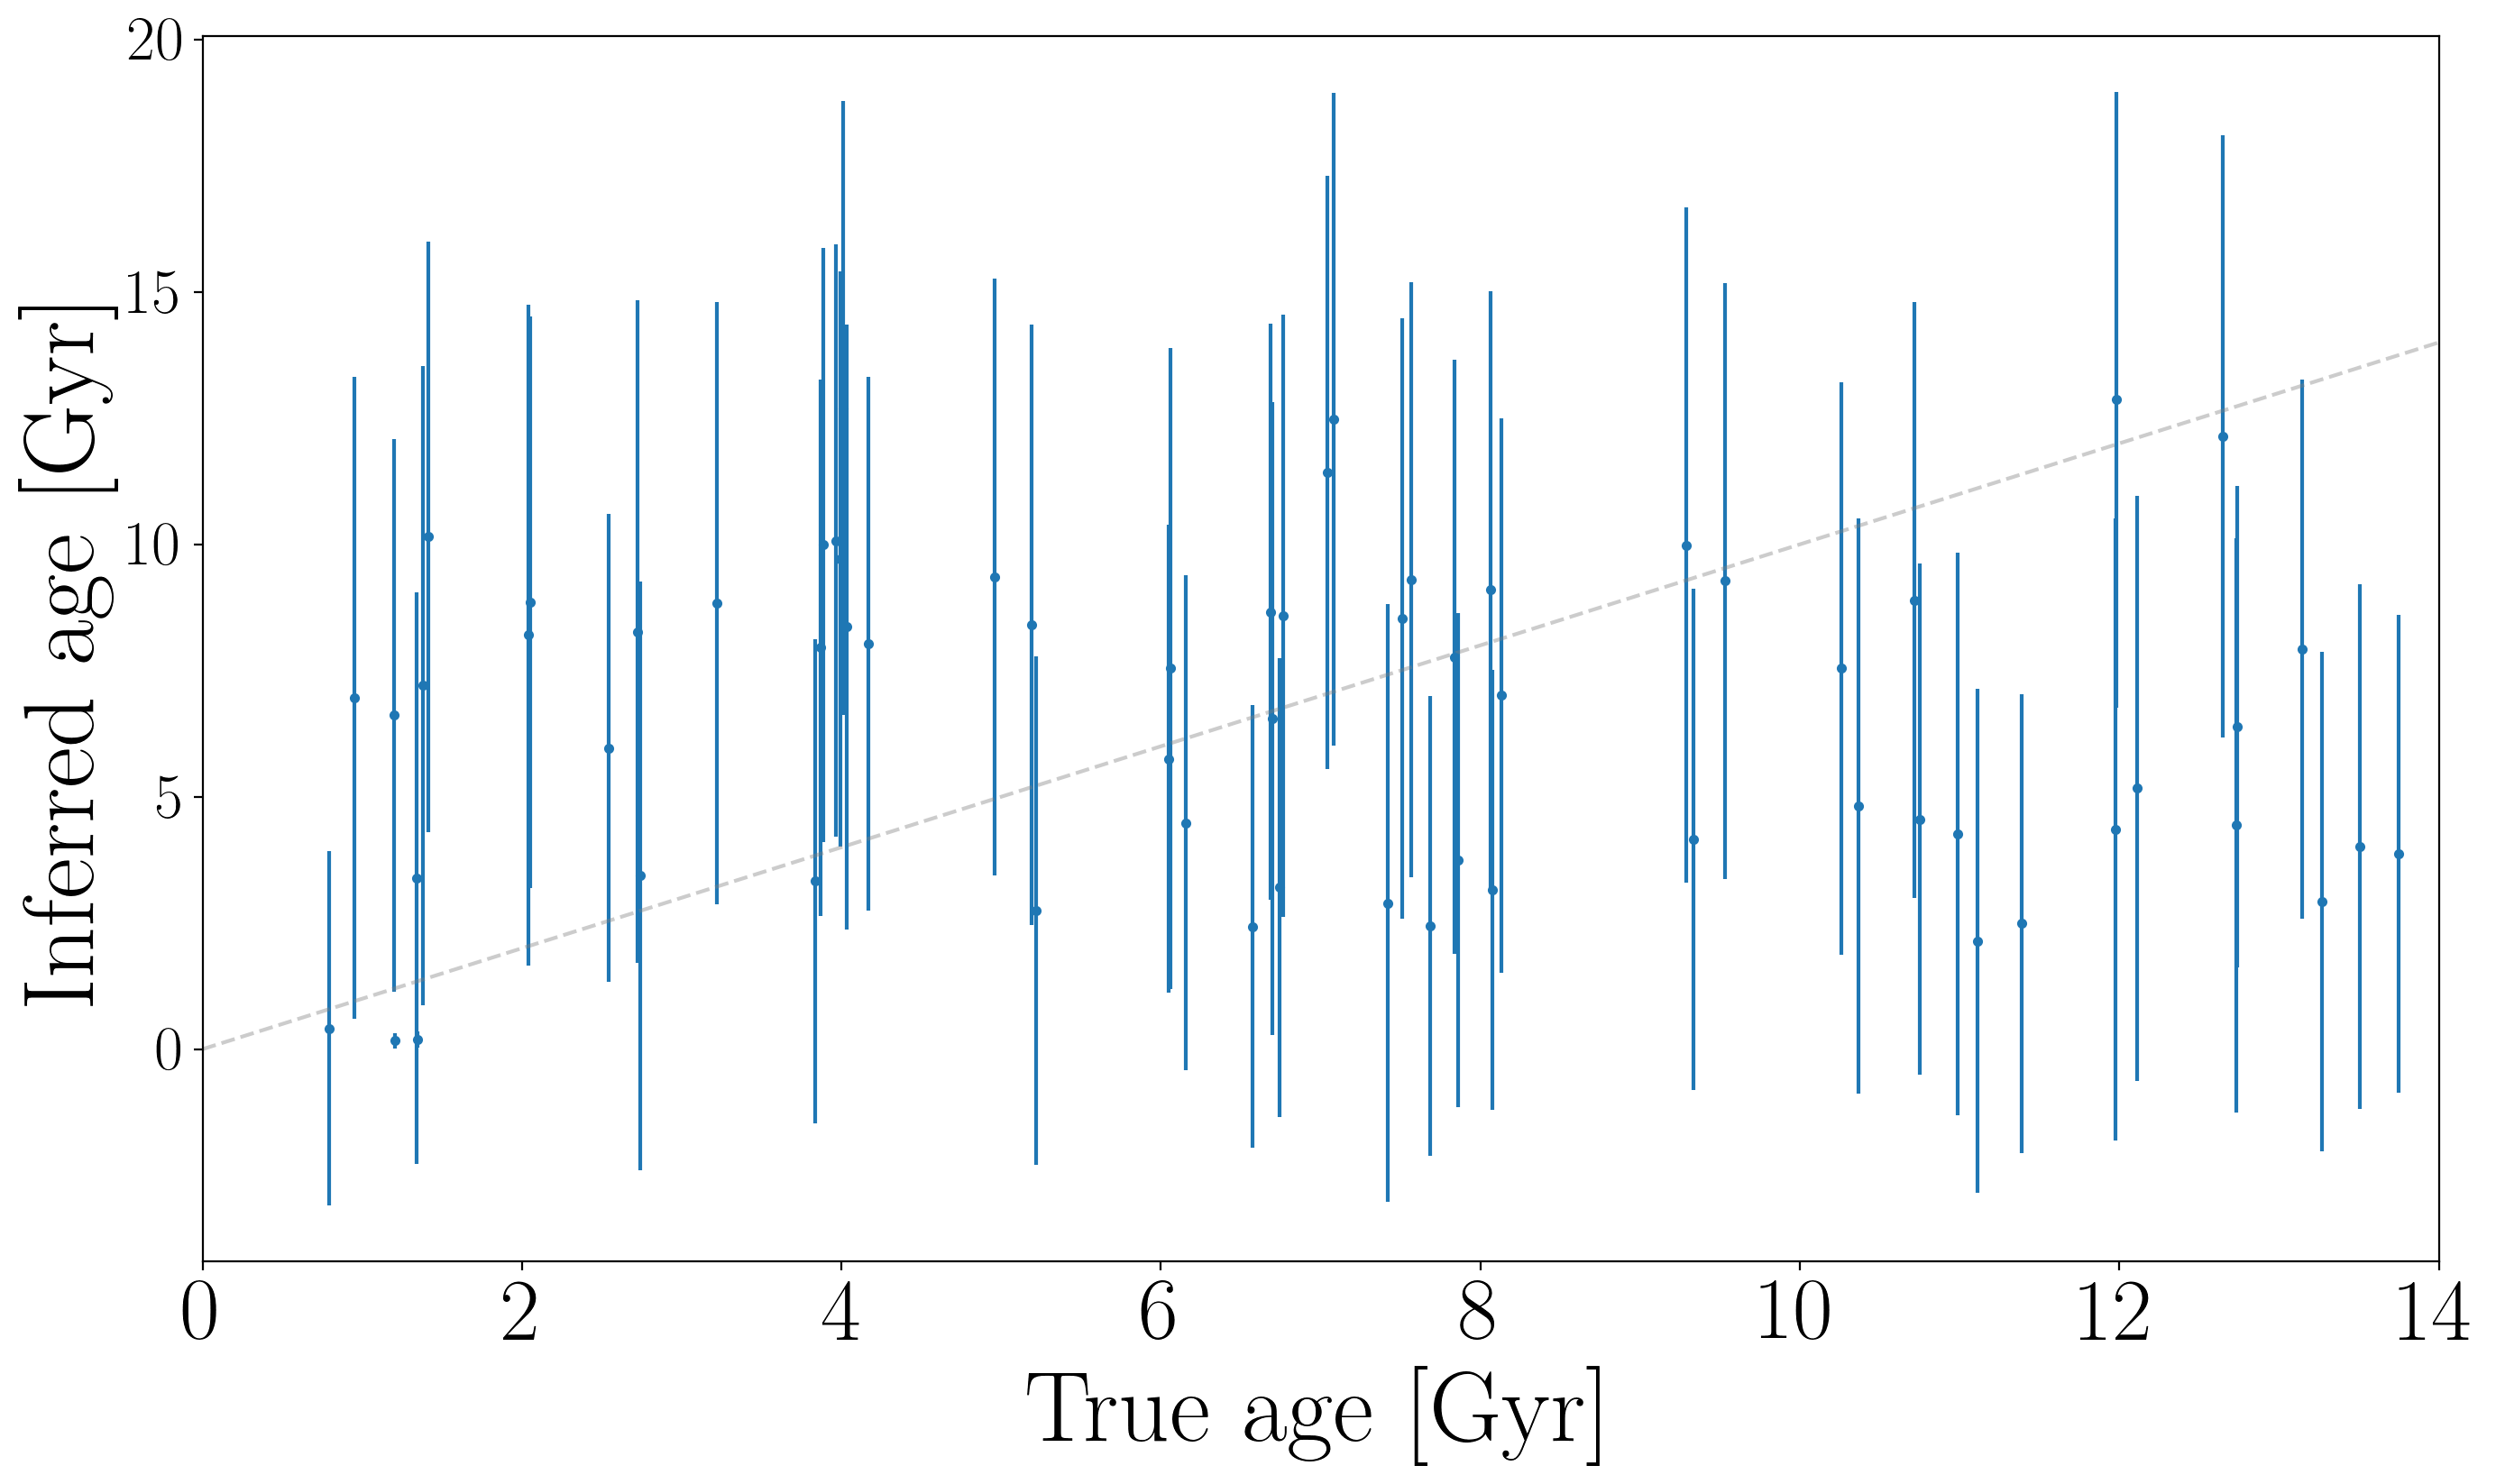

In [113]:
plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar((10**df.age.values[:N_iso])*1e-9, meds_iso, yerr=stds_iso, fmt=".")
plt.errorbar((10**df.age.values[:N_iso])*1e-9, meds_iso, yerr=stds_iso, fmt=".")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.savefig("iso_only.pdf")

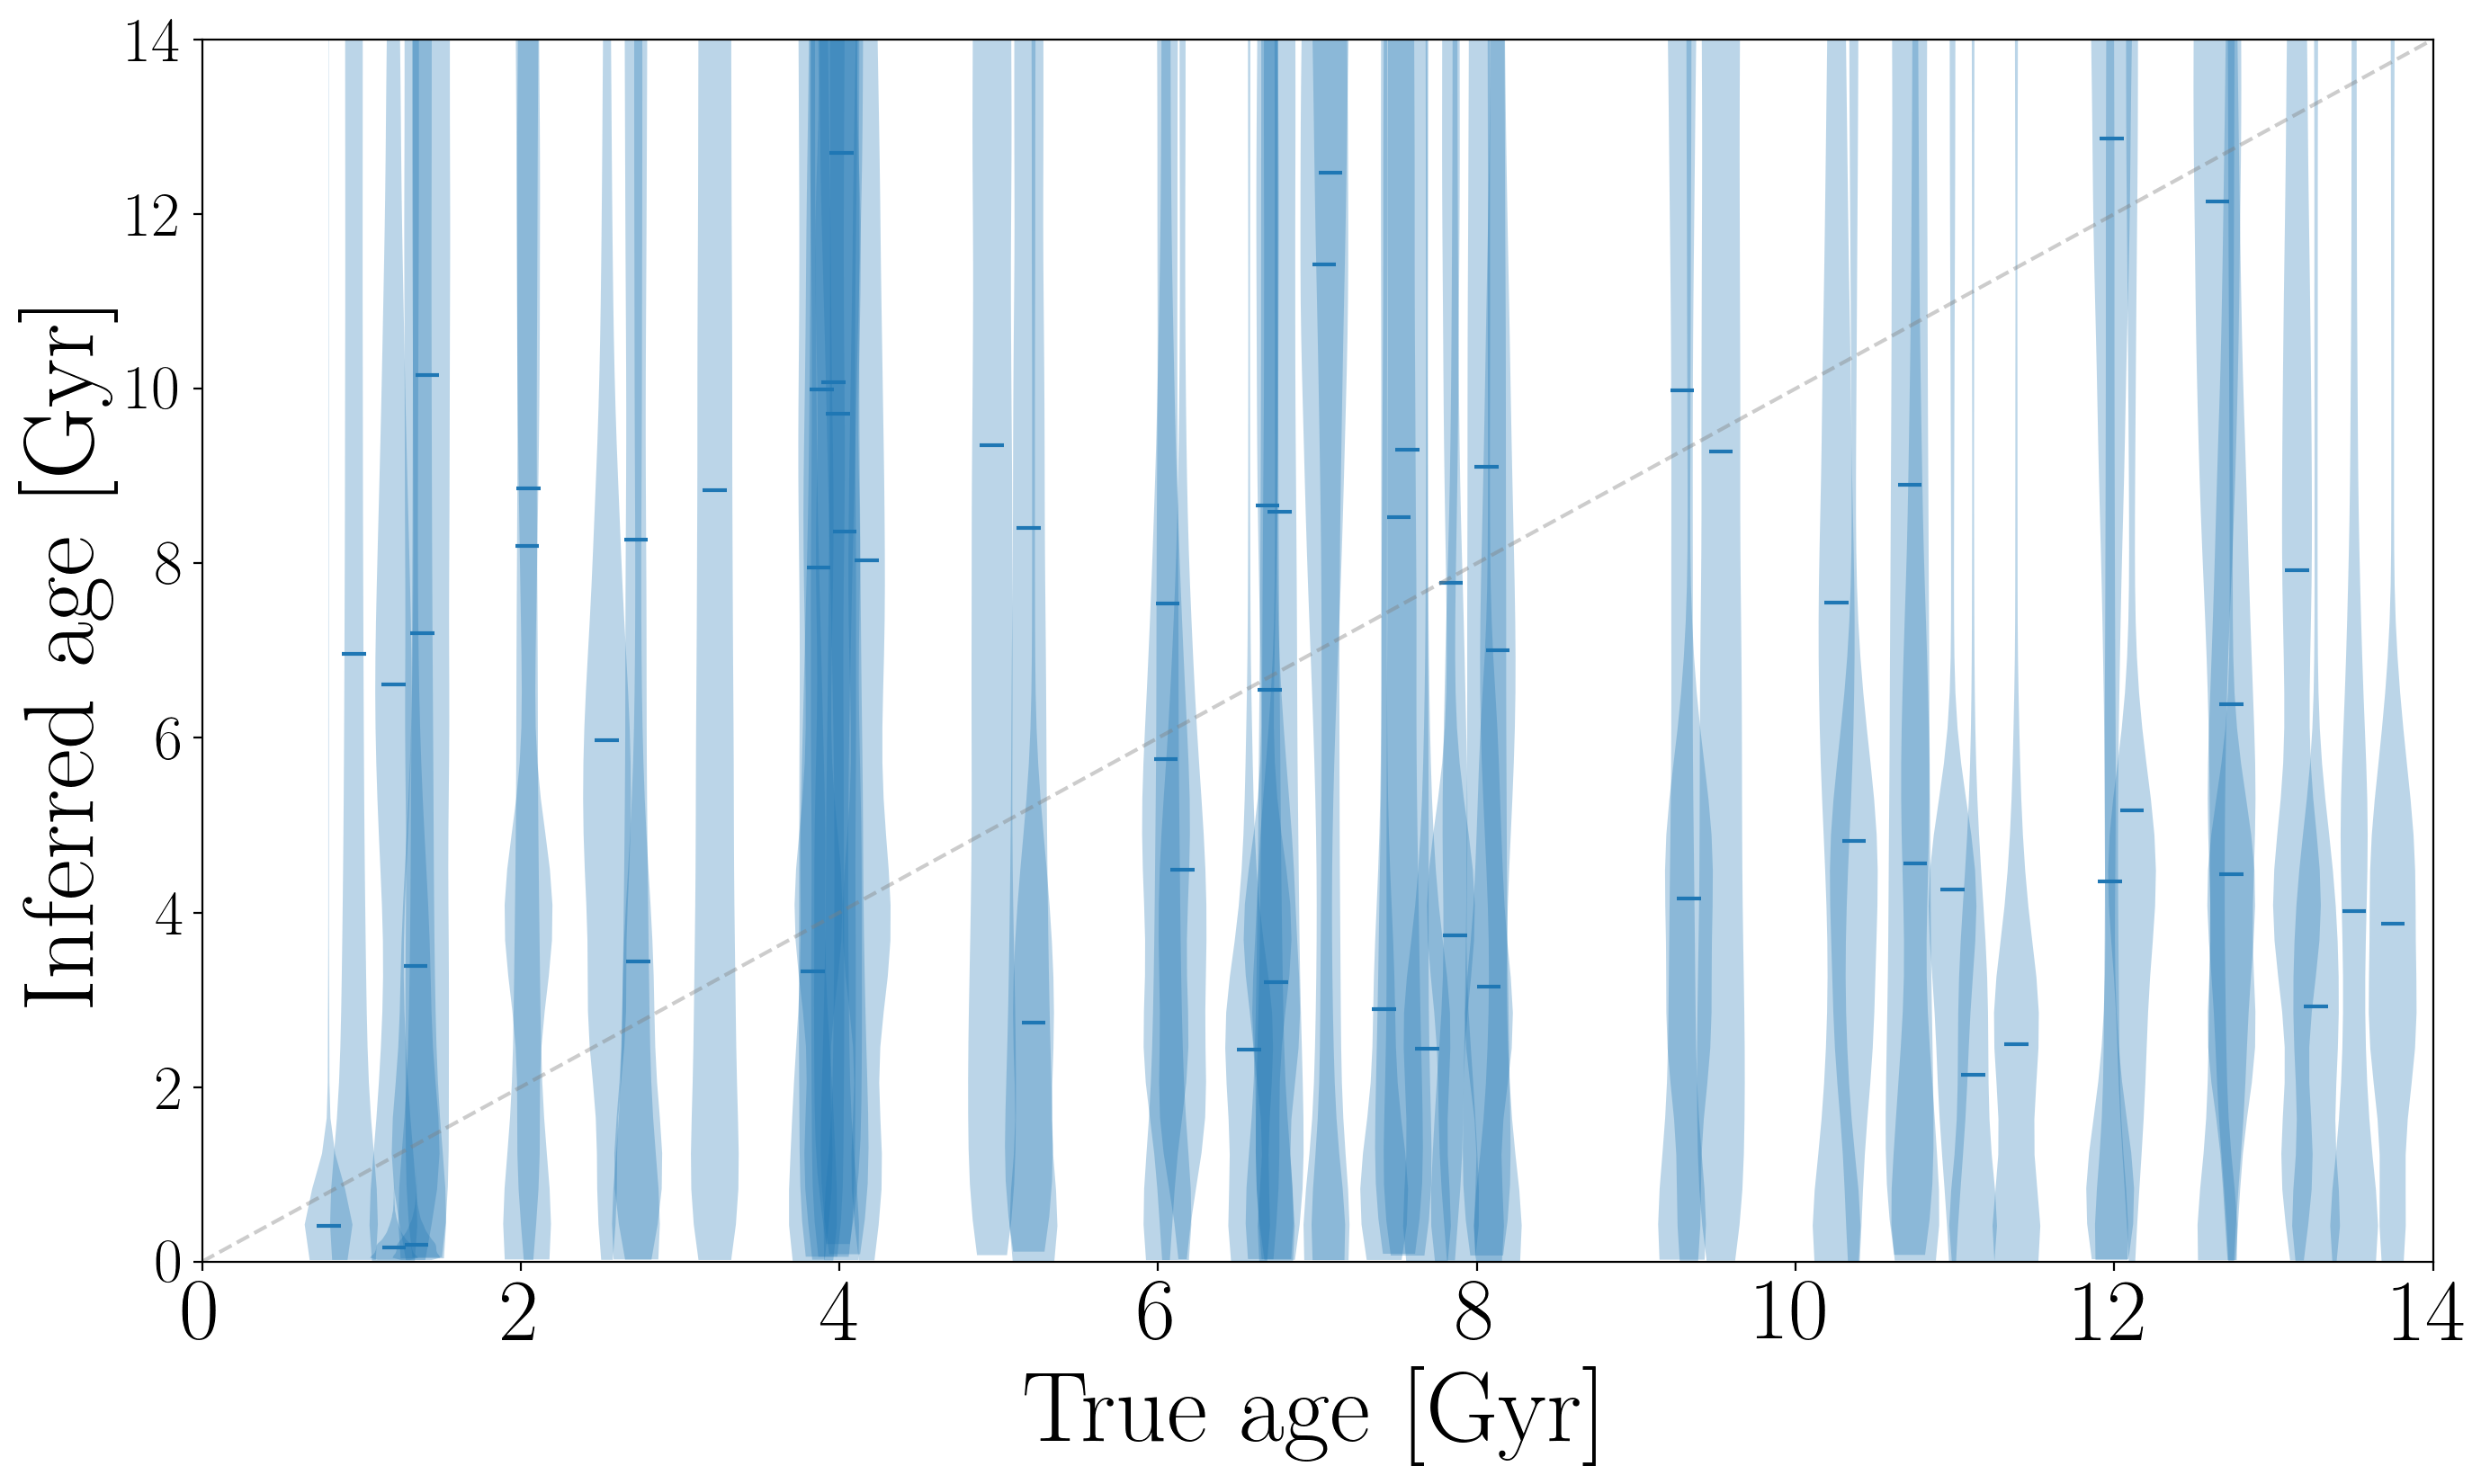

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
mm = m[:N_iso]
axes.violinplot(age_samps_iso, true_age_gyr[:N_iso], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=True)
# axes.violinplot(age_samps_iso[mm], true_age_gyr[:N_iso][mm], points=50, widths=0.3, color="tab:orange",
#                 showmeans=False, showextrema=False, showmedians=False)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.savefig("iso_only_violin.pdf")

Text(0,0.5,'$\\log(g)$')

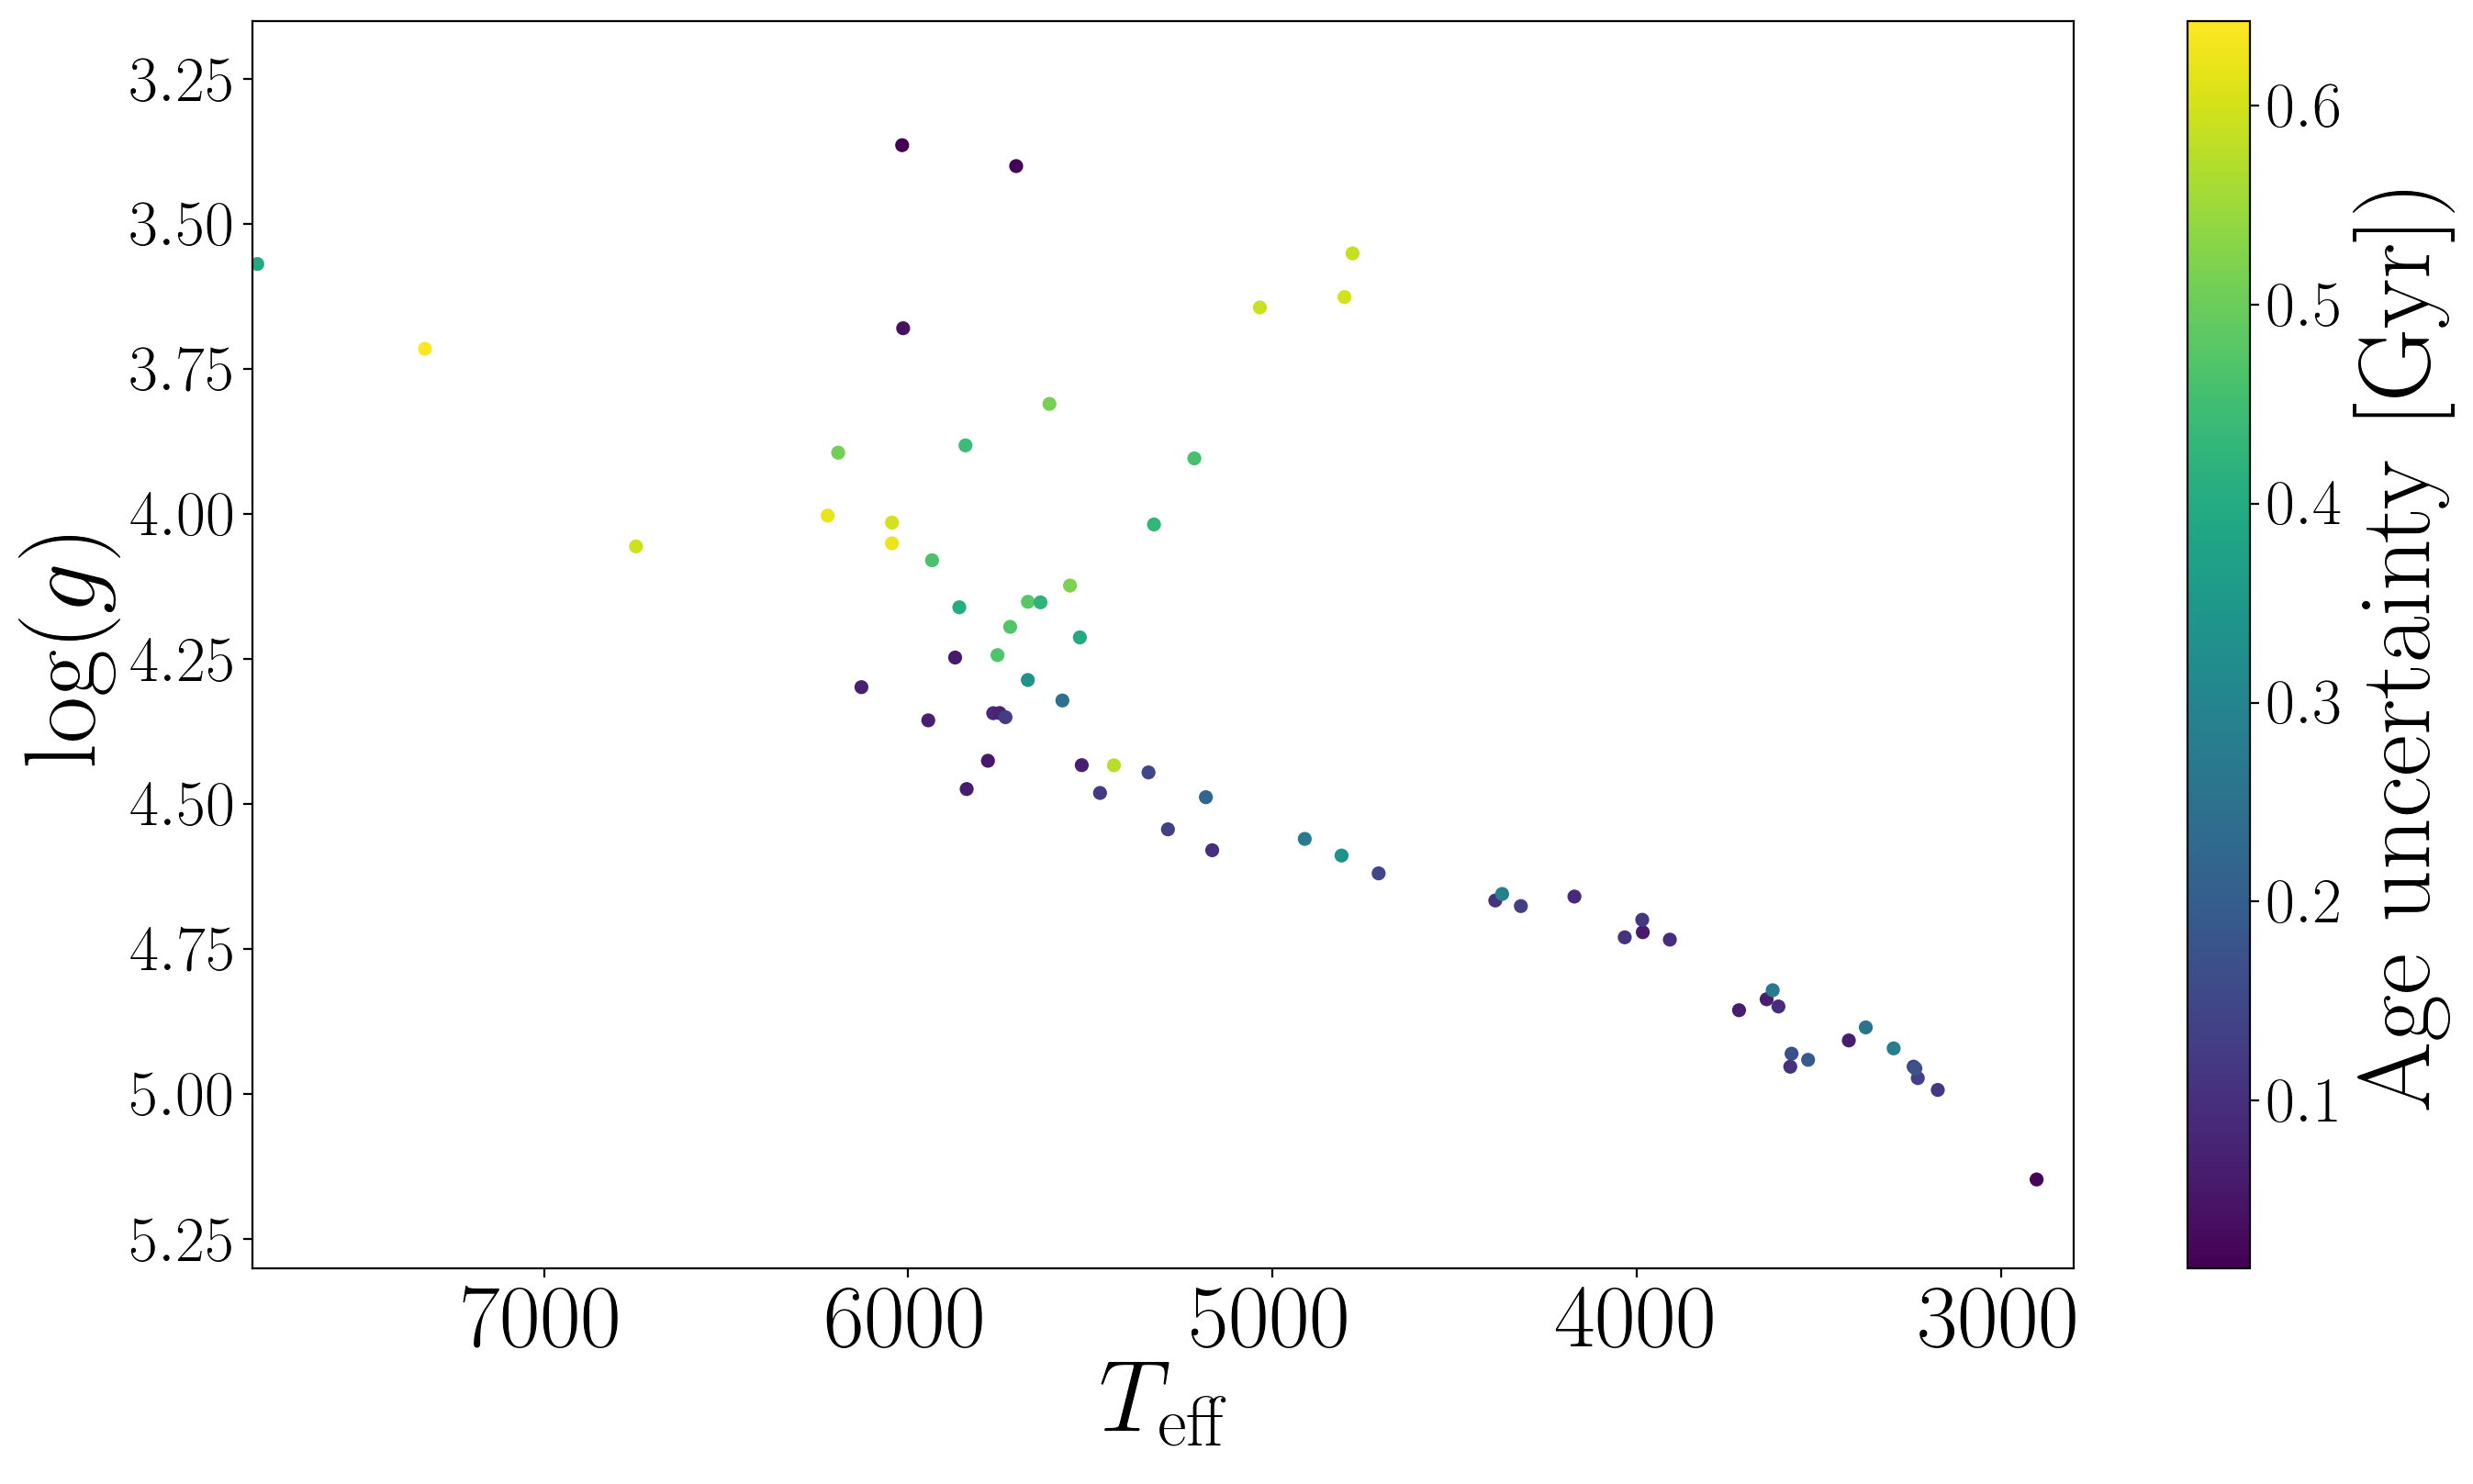

In [115]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=stds/df.age.values[:N], s=20)
plt.colorbar(label="$\mathrm{Age~uncertainty~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Text(0,0.5,'$\\log(g)$')

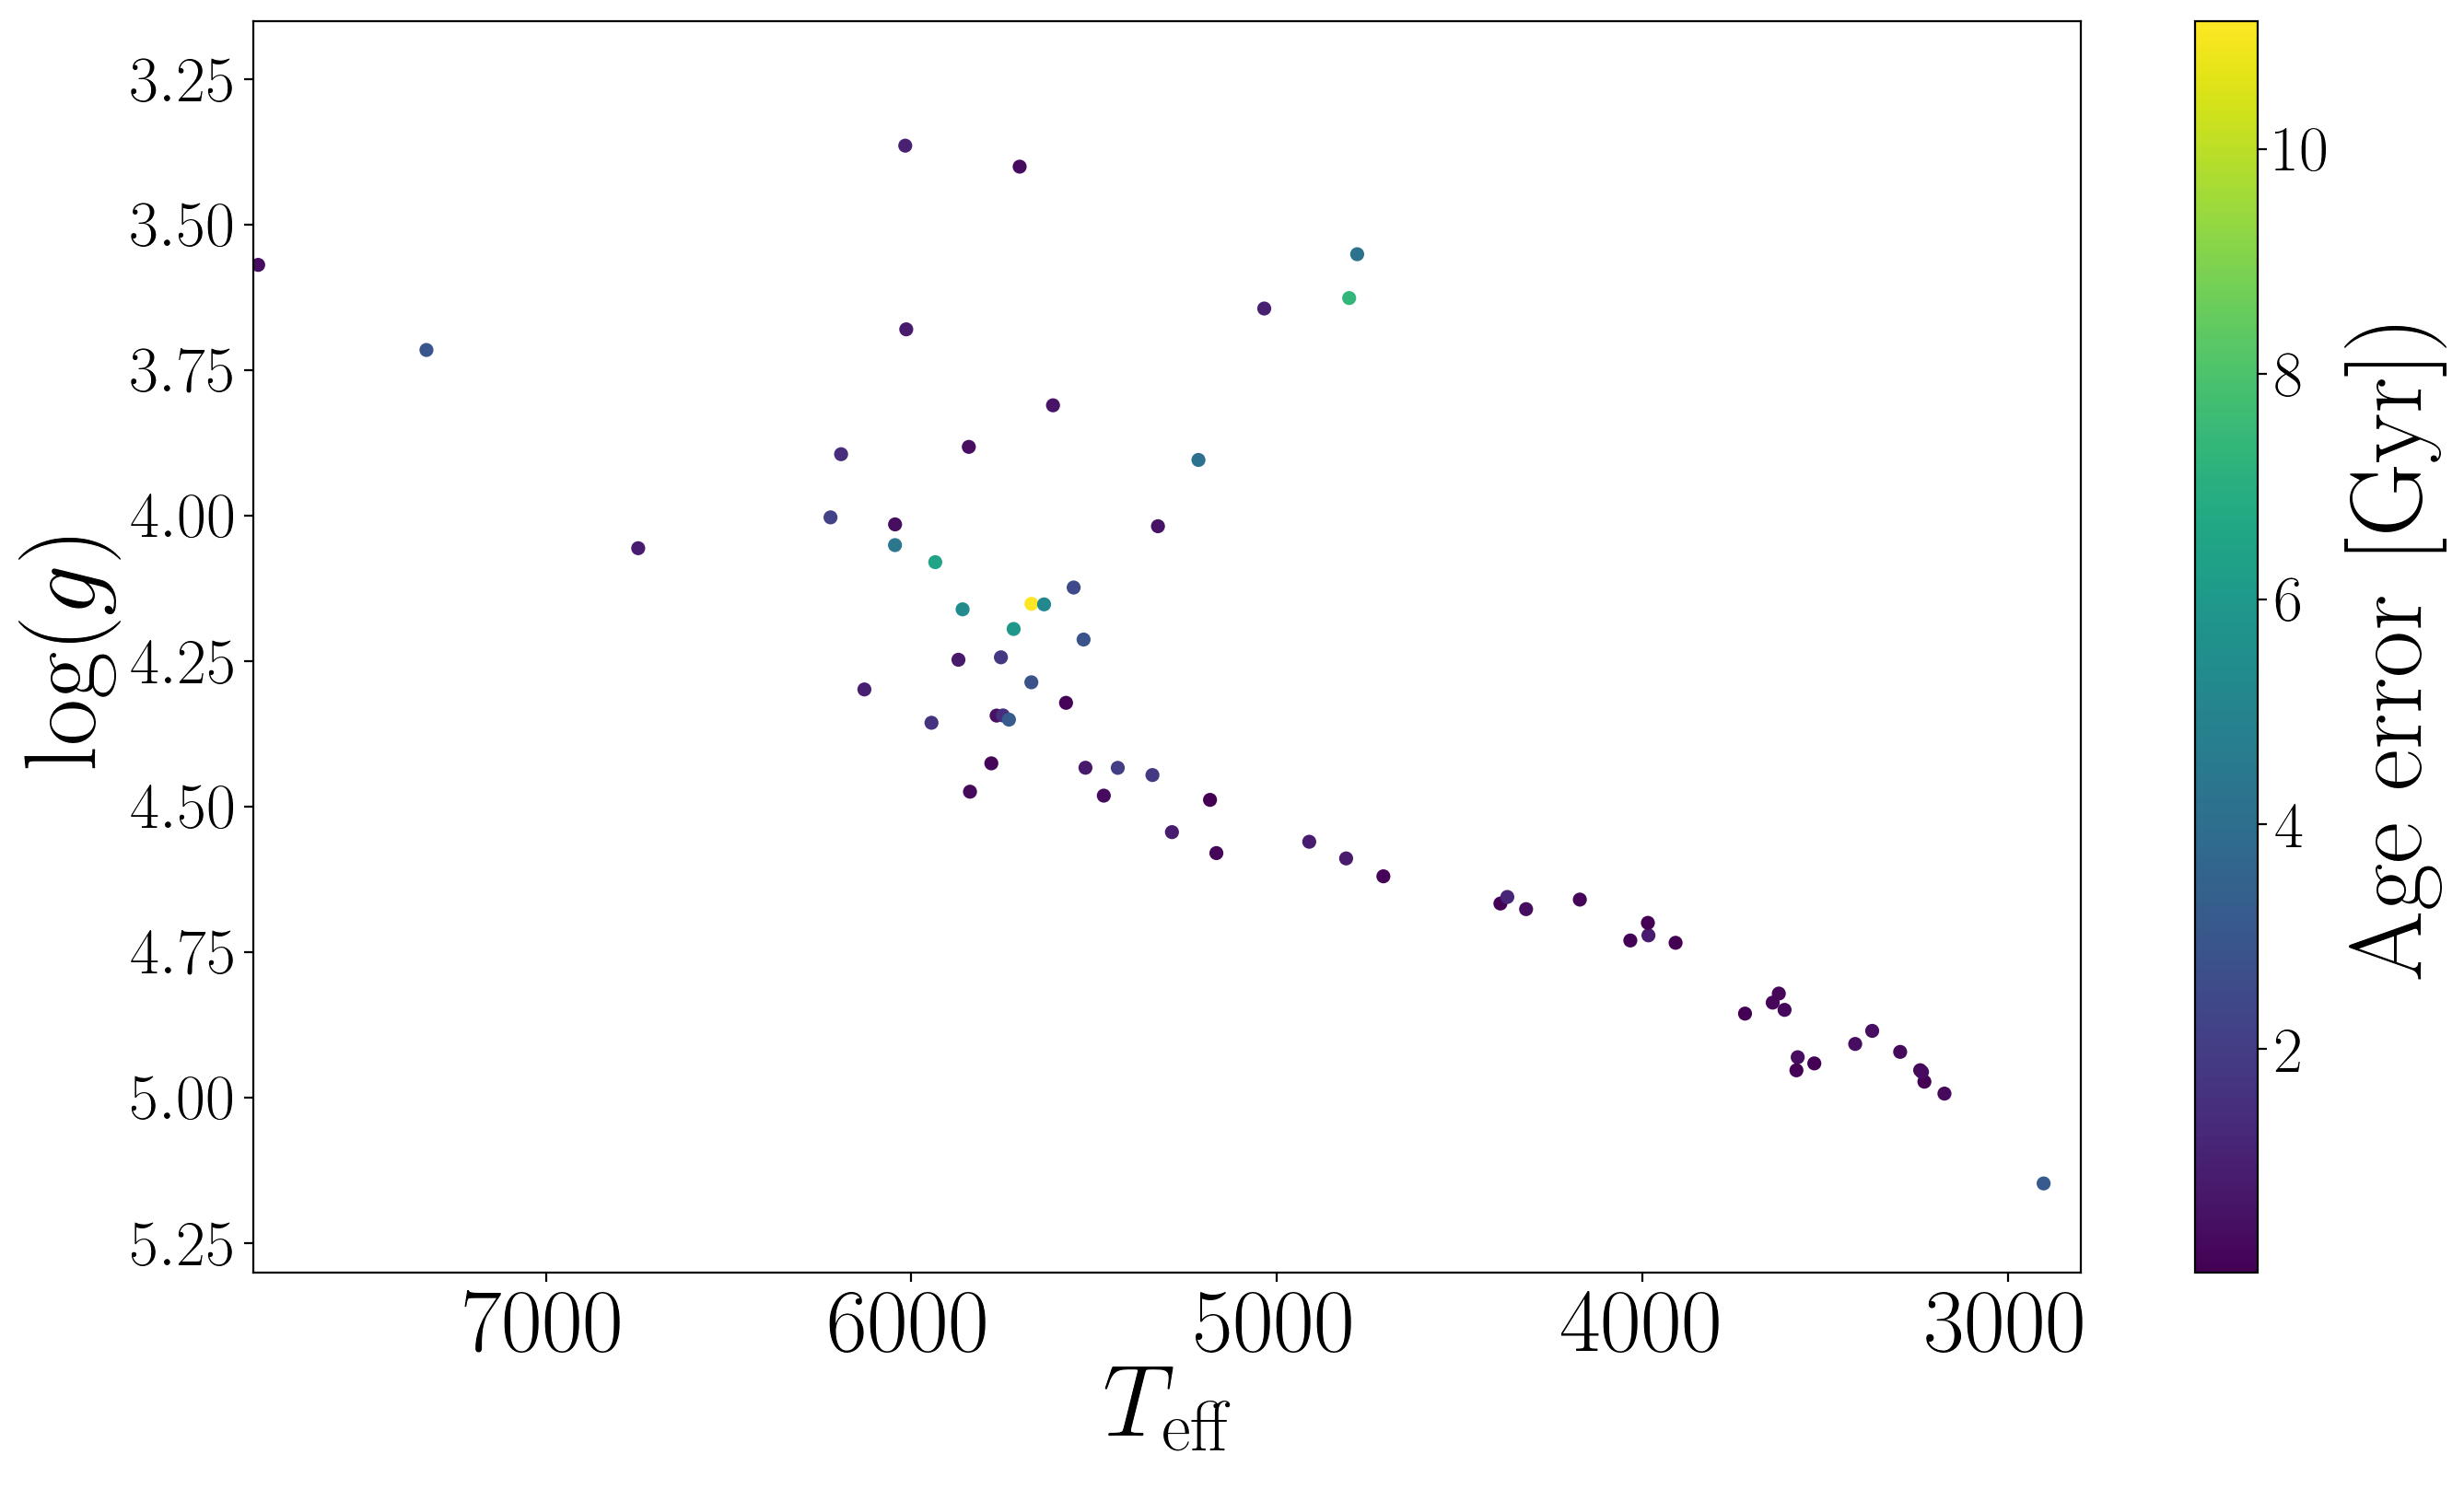

In [116]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=abs(true_age_gyr[:N] - meds), s=20)
plt.colorbar(label="$\mathrm{Age~error~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the gyrochronology model.

In [12]:
savedir = "simulation_results/gyro_only"
meds_gyro, stds_gyro = [], []
N = 80
for i in range(N):
    with h5py.File("{0}/{1}.h5".format(savedir, str(i).zfill(4)), "r") as f:
            samples = f["samples"][...]
            age_samps = (10**samples[:, 1])*1e-9
            meds_gyro.append(np.median(age_samps))
            stds_gyro.append(np.std(age_samps))

OSError: Unable to open file (Unable to open file: name = 'simulation_results/gyro_only/0000.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
plt.figure(figsize=(16, 9))
plt.errorbar((10**df.age.values[:N])*1e-9, meds_gyro, yerr=stds_gyro, fmt=".")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)

# Now load results from Cluster runs.

In [ ]:
savedir = "cluster_results/iso_and_gyro"
meds, stds, age_samps, resids, errp, errm = [], [], [], [], [], []
mass_samps, feh_samps, dist_samps, av_samps = [], [], [], []
N = 19

for i in trange(N):
    fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    
    reader = emcee.backends.HDFBackend(fname, read_only=True)
    flatchain = reader.get_chain(flat=True)

    mass_samps.append(flatchain[10000:, 0])
    feh_samps.append(flatchain[10000:, 2])
    dist_samps.append(flatchain[10000:, 3])
    av_samps.append(flatchain[10000:, 4])
    age_samps.append((10**flatchain[10000:, 1])*1e-9)
    resids.append(list(np.array(age_samps[i]) - .65))
    meds.append(np.median(age_samps[i]))
    stds.append(np.std(age_samps[i]))
    upper = np.percentile(age_samps[i], 84)
    lower = np.percentile(age_samps[i], 16)
    errp.append(upper-meds[i])
    errm.append(meds[i]-lower)
    
meds, stds, errp, errm = np.array(meds), np.array(stds), np.array(errp), np.array(errm)

In [ ]:
savedir = "cluster_results/iso_only"
meds_iso, stds_iso, age_samps_iso, resids_iso, errp_iso, errm_iso = [], [], [], [], [], []
mass_samps_iso, feh_samps_iso, dist_samps_iso, av_samps_iso = [], [], [], []
N_iso = 5

for i in trange(N_iso):
    fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    
    reader = emcee.backends.HDFBackend(fname, read_only=True)
    flatchain_iso = reader.get_chain(flat=True)

    mass_samps_iso.append(flatchain_iso[10000:, 0])
    feh_samps_iso.append(flatchain_iso[10000:, 2])
    dist_samps_iso.append(flatchain_iso[10000:, 3])
    av_samps_iso.append(flatchain_iso[10000:, 4])
    age_samps_iso.append((10**flatchain_iso[10000:, 1])*1e-9)
    resids_iso.append(list(np.array(age_samps_iso[i]) - .65))
    meds_iso.append(np.median(age_samps_iso[i]))
    stds_iso.append(np.std(age_samps_iso[i]))
    upper = np.percentile(age_samps_iso[i], 84)
    lower = np.percentile(age_samps_iso[i], 16)
    errp_iso.append(upper-meds[i])
    errm_iso.append(meds[i]-lower)
    
meds_iso, stds_iso, errp_iso, errm_iso = np.array(meds_iso), np.array(stds_iso), np.array(errp_iso), np.array(errm_iso)

In [ ]:
xs = np.linspace(0, 14, 1000)
plt.figure(figsize=(16, 9))
    
for i in trange(N):
    kernel = sps.gaussian_kde(age_samps[i][::100])
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.2, color="tab:blue")    

for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(age_samps_iso[i][::100])
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.3, color="tab:orange")

plt.axvline(.65, color="k", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.xlim(0, 14)
plt.savefig("../plots/cluster_ages.pdf")
# plt.ylim(0, 1)

In [ ]:
xs = np.linspace(0, 1, 1000)
plt.figure(figsize=(16, 9), dpi=200)
    
for i in trange(N):
    kernel = sps.gaussian_kde(feh_samps[i][::100])
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.2, color="tab:blue")
    
for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(feh_samps_iso[i][::100])
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.3, color="tab:orange")

    
#     ([Fe/H] = 0.11±0.03)  Fossati et al https://arxiv.org/pdf/0803.3540.pdf
plt.axvline(.14, color="k")
plt.xlabel("$\mathrm{[Fe/H]}$")
plt.xlim(0, 1)
plt.savefig("../plots/cluster_fehs.pdf")
# plt.ylim(0, 1)

In [ ]:
xs = np.linspace(150, 230, 1000)
plt.figure(figsize=(16, 9), dpi=200)
    
for i in trange(N):
    kernel = sps.gaussian_kde(np.exp(dist_samps[i][::100]))
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.5, color="tab:blue")

for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(np.exp(dist_samps_iso[i][::100]))
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.5, color="tab:orange")
    
plt.axvline(177, color="k")
plt.xlabel("$\mathrm{Distance~[pc]}$")
plt.xlim(150, 230)
plt.savefig("../plots/cluster_distances.pdf")

In [ ]:
xs = np.linspace(0, 1, 1000)
plt.figure(figsize=(16, 9), dpi=200)

for i in trange(N):
    kernel = sps.gaussian_kde(av_samps[i][::100])
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.2, color="tab:blue")

for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(av_samps_iso[i][::100])
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.3, color="tab:orange")    
    
plt.xlabel("$A_v$")
plt.xlim(0, 1)
plt.savefig("../plots/cluster_avs.pdf")

In [ ]:
xs = np.linspace(0, 10, 1000)
plt.figure(figsize=(16, 9), dpi=200)
    
for i in trange(N):
    m_samps = mist.mass(mass_samps[i][::100], age_samps[i][::100], feh_samps[i][::100])
    print(type(m_samps[np.isfinite(m_samps)]), np.shape(m_samps[np.isfinite(m_samps)]))
    try:
        kernel = sps.gaussian_kde(m_samps[np.isfinite(m_samps)])
        plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.5, color="tab:blue")
    except:
        pass

for i in trange(N_iso):
    m_samps_iso = mist.mass(mass_samps_iso[i][::100], age_samps_iso[i][::100], feh_samps_iso[i][::100])
    try:
        kernel_iso = sps.gaussian_kde(np.exp(m_samps_iso[np.isfinite(m_samps_iso)]))
        plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.5, color="tab:orange")
    except:
        pass
    
# plt.axvline(177, color="k")
plt.xlabel("$\mathrm{Mass~[M}_\odot]$")
# plt.xlim(150, 230)
plt.savefig("../plots/cluster_masses.pdf")

In [ ]:
path = "../data/00100M.track.csv"
df = pd.read_csv(path, skiprows=11)
print(df.keys())
print(np.shape(df))

In [ ]:
plt.plot(10**(df.log_Teff), 10**(df.log_L))
plt.xlim(8000, 3000)
plt.ylim(0, 3)